Question:  'When does the spread of antibacterial resistance frequently occurs/'
Predicted Answer:  through vertical transmission of mutations during growth
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    232
my answer is  through vertical transmission of mutations during growth
positive contribution: tensor(4.0134, device='cuda:0', dtype=torch.float64)
negative contribution: tensor(-6.2340, device='cuda:0', dtype=torch.float64)
should delete 15 -0.8352836201199807
Question:  'When does the spread of antibacterial resistance frequently occurs/'
Predicted Answer:  vertical transmission of mutations during growth
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    198
should delete 5 0.08876278445305702
Question:  'When does the spread of antibacterial resistance frequently occurs/'
Predicted Answer:  vertical transmission of mutations during growth
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    195
should delete 7 0.01308390396961255
Question:  'When does the spread of antibacterial resistance frequently occurs/'
Predicted Answer:  through vertical transmission of mutations during growth
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    175
should delete 6 -0.7810665780861216
Question:  'When does the spread of antibacterial resistance frequently occurs/'
Predicted Answer:  through vertical transmission of mutations during growth
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    154
should delete 9 0.03493044170164341
Question:  'When does the spread of antibacterial resistance frequently occurs/'
Predicted Answer:  through vertical transmission of mutations during growth
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    151
[0.511673167347908, 0.5150416940450668, 0.5217716693878174, 0.5658615827560425, 0.558703750371933, 0.5632656216621399] [0.5757103562355042, 0.5806477665901184, 0.5881640315055847, 0.5955312848091125, 0.507207453250885, 0.5058310627937317] [0.4476359784603119, 0.44943562150001526, 0.45537930727005005, 0.5361918807029724, 0.610200047492981, 0.6207001805305481]


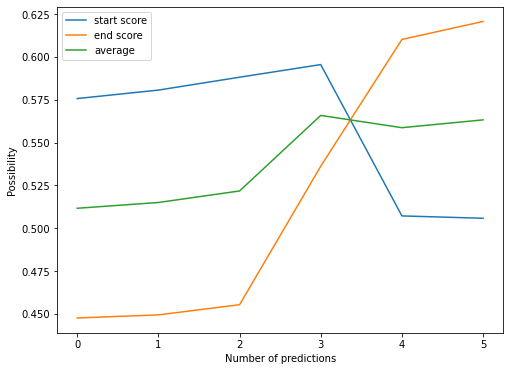

through vertical transmission of mutations during growth
vertical transmission of mutations during growth
vertical transmission of mutations during growth
through vertical transmission of mutations during growth
through vertical transmission of mutations during growth
through vertical transmission of mutations during growth


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from datasets import load_dataset

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)


def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                   position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits


def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values


fig = plt.figure()
fig.set_size_inches(8, 6)

ref_token_id = tokenizer.pad_token_id  # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id  # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id  # A token used for prepending to the concatenated question-text word sequence


def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def predict_qt(question, text):
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id,
                                                                cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'

    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)

    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens,


def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores,
            ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                        token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    # print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    # print("all tokens:    ", len(all_tokens))

    return all_tokens, attributions_start_sum


def get_posneg(all_tokens, attributions_start_sum):
    positive = []
    negative = []
    neutral = []
    for i, j in enumerate(attributions_start_sum):
        if j > 0:
            positive.append(i)
            # print('positive:',j)
        ##print(all_tokens[i])
        elif j < 0:
            negative.append(i)
            # print('negative:',j)
            # print(all_tokens[i])
        elif j == 0:
            neutral.append(i)

    s_pos = ''
    s_neg = ''

    # print(len(attributions_start_sum))
    # print(len(positive))
    # print(len(negative))

    for i in positive:
        s_pos += all_tokens[i] + ' '
    # print("positive :", s_pos)
    for i in negative:
        s_neg += all_tokens[i] + ' '
    # print("negative :", s_neg)
    return positive, negative, neutral


def separate_sentence(all_tokens):
    sentence = {}
    temp = []
    num = 0
    for i in range(len(all_tokens)):
        if all_tokens[i] == "," or all_tokens[i] == ".":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[CLS]":
            temp.append(all_tokens[i])
            sentence[num] = temp
            temp = []
            num = num + 1
        elif all_tokens[i] == "[SEP]":
            sentence[num] = temp
            num = num + 1
            temp = [all_tokens[i]]
            sentence[num] = temp
            temp = []
            num = num + 1
        else:
            temp.append(all_tokens[i])
    return sentence


def get_sence_score(sentence, attributions_start_sum):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = []
    for k, v in sentence.items():
        for i in v:
            sentence_value.append(i)
    scores = {}

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            sum_weight += scores[word]
        delete_sentence.append(sum_weight)
        # print(sum_weight)
    return delete_sentence


def get_delete(sentence):
    weight = 0
    sum_weight = 0
    sentence_value = []
    delete_sentence = {}
    for k, v in sentence.items():
        # print(k,':',v)
        for i in v:
            sentence_value.append(i)
    # print(sentence_value)
    scores = {}
    # print(attributions_start_sum[0].item())

    for i in range(len(attributions_start_sum)):
        try:
            scores[sentence_value[i]] = attributions_start_sum[i].item()
        except:
            pass

    for i, j in sentence.items():
        sum_weight = 0
        for word in j:
            weight = 0

            sum_weight += scores[word]
            delete_sentence[i] = sum_weight
    return delete_sentence


def delete_sentence(sentence, li_delete_sentence):
    for i, j in sentence.items():
        if i in li_delete_sentence:
            sentence[i] = []
        else:
            pass
    return sentence


def rebuild_sentence(ori_sentence):
    rebuild_str = ""
    for i, j in ori_sentence.items():
        for word in j:
            rebuild_str += word
            rebuild_str += " "
    return rebuild_str


def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, = predict_qt(
        question, text)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask,
                                                 start_scores, end_scores, ground_truth, all_tokens, )

    end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
    start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
    return all_tokens, attributions_start_sum, end_score, start_score, [torch.argmax(start_scores), torch.argmax(
        end_scores) + 1], start_scores, end_scores


def max_min(x, y, z):
    max = min = x
    i = 1
    if y > max:
        max = y
        i = 2
    else:
        min = y
    if z > max:
        max = z
        i = 3
    else:
        min = z
    return (i)


def rebuild_text(all_tokens, attributions_start_sum):

    li_sep = []
    min_sensocer = 999
    min_index = 999
    sentence = separate_sentence(all_tokens)
    sentence_score = get_sence_score(sentence, attributions_start_sum)

    for i in range(len(sentence_score)):
        if sentence_score[i] < min_sensocer and sentence_score[i] != 0:
            min_sensocer = sentence_score[i]
            min_index = i
    print("should delete", min_index, min_sensocer)

    # temp = []
    # for i in sentence_score:
    #     temp.append(abs(i))
    # sentence[sentence_score.index(min(temp))] = ''

    temp = []
    for i in sentence_score:
        temp.append(abs(i))
    sentence[min_index] = ''
    sentence[1] = ''
    retext = ""
    for i, j in sentence.items():
        for words in j:
            retext = retext + words + " "
    #这是清楚 ## 等模型引入的字符串
    for m in re.finditer(r"SEP", retext):
        li_sep.append(m.start())
        li_sep.append(m.end())
    retext = retext[li_sep[1] + 1: li_sep[2] - 1]
    retext = re.sub(r' ##', '', retext)
    return retext


def cycle_prediction(cycle_num, question, text):
    all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(question,
                                                                                                              text)
    first_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
    first_answer = re.sub(r' ##', '', first_answer)
    print("my answer is ", first_answer)
    pos_contri = 0
    neg_contri = 0
    average_neg = []
    average_pos = []
    for i, j in enumerate(attributions_start_sum):
        if j < 0:
            neg_contri += j
        elif j > 0:
            pos_contri += j
    print("positive contribution:", pos_contri)
    average_pos.append(pos_contri)
    print("negative contribution:", neg_contri)
    average_neg.append(neg_contri)

    acc_s = []
    acc_e = []
    ans = []
    ans.append(first_answer)
    # print(start_acc, end_acc)
    acc_s.append(start_acc)
    acc_e.append(end_acc)

    for loop in range(cycle_num):
        retext = rebuild_text(all_tokens, attributions_start_sum)


        all_tokens, attributions_start_sum, start_acc, end_acc, an_index, start_scores, end_scores = pred_explain(
            question, retext)
        reanswer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        # print(start_acc, end_acc)
        second_answer = ' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores) + 1])
        second_answer = re.sub(r' ##', '', second_answer)
        # print("my answer is ", second_answer)
        ans.append(second_answer)
        # print(start_acc, end_acc)
        acc_s.append(start_acc)
        acc_e.append(end_acc)

    plt.plot(range(len(acc_s)), acc_s, label='start score')
    plt.plot(range(len(acc_s)), acc_e, label='end score')
    sun = []
    for i in range(len(acc_s)):
        sun.append((acc_s[i] + acc_e[i]) / 2)
    print(sun, acc_s, acc_e)
    plt.plot(range(len(acc_s)), sun, label='average')
    plt.xlabel('Number of predictions')
    plt.ylabel('Possibility')
    plt.legend()
    plt.show()

    for i in range(len(ans)):
        print(ans[i])


text = """Several molecular mechanisms of antibacterial resistance exist. Intrinsic antibacterial resistance may be part of the genetic makeup of bacterial strains. For example, an antibiotic target may be absent from the bacterial genome. Acquired resistance results from a mutation in the bacterial chromosome or the acquisition of extra-chromosomal DNA. Antibacterial-producing bacteria have evolved resistance mechanisms that have been shown to be similar to, and may have been transferred to, antibacterial-resistant strains. The spread of antibacterial resistance often occurs through vertical transmission of mutations during growth and by genetic recombination of DNA by horizontal genetic exchange. For instance, antibacterial resistance genes can be exchanged between different bacterial strains or species via plasmids that carry these resistance genes. Plasmids that carry several different resistance genes can confer resistance to multiple antibacterials. Cross-resistance to several antibacterials may also occur when a resistance mechanism encoded by a single gene conveys resistance to more than one antibacterial compound."""



question = """'When does the spread of antibacterial resistance frequently occurs/'"""

cycle_prediction(5, question, text)






